In [2]:
#Reference

#https://python.langchain.com/docs/tutorials/rag/
#https://www.youtube.com/watch?v=yF9kGESAi3M&t=3823s


#The RAG has two main components

#Indexing - taking data from source and indexing it , happens offline
# in other words ,
# (Document Loaders) take/load data
# (Text Splitters) break it down to chunks
# (Embedding model)convert the chunks to embeddings
# (Vector store)store the data inform of embeddings

#Retrieval- the RAG chain, takes user query at runtime, retrieves relevant data from index, then passes to the model
# will be in more detail in RAG part b



In [3]:
# select chatmodel
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from textdistance import overlap

load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

llm=init_chat_model("gpt-4o-mini", model_provider="openai")


In [4]:
#having issue with openai embedding
#from langchain_openai import OpenAIEmbeddings
#embeddings=OpenAIEmbeddings(model="text-embedding-3-large")

#replaced it with hugging face embedding

from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


In [5]:
#tried using vector stores,inmemory, had issues when i tried to implement it like this
# hence used FAISS
#from langchain_core.vectorstores import InMemoryVectorStore
#vector_store=InMemoryVectorStore(embeddings)


In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
# we will receive a html file
# we are going to select only title, header and content  from the html
bs4_strainer=bs4.SoupStrainer(class_=("post-title","post-header","post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs=loader.load()
assert len(docs)==1
print(f"Total document length(characters) {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total document length(characters) 43130


In [7]:
#spliting the document for vector storage
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)
all_splits=text_splitter.split_documents(docs)
print(len(all_splits))
print(all_splits[0])
#print(len(all_splits[65]))


66
page_content='LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory' metadata={'s

In [8]:

from langchain.vectorstores import FAISS
vector_store = FAISS.from_documents(documents=all_splits, embedding=embeddings)
#storing documents
document_ids=vector_store.add_documents(documents=all_splits)
print(document_ids[0:5])

['fca3575b-0684-4975-9355-b6f5b29ad790', 'a1834f19-762c-43fa-8192-33ab62d8a939', '067c63cd-f3ac-4776-81e6-d7039e3ea86c', 'a882b648-9524-4bed-907c-79cb2a111c90', '297bbfd7-5666-4b4f-8c5e-fa28fd9d48d8']


In [9]:
# Retrieval and generation
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")
#example_messages=

/opt/anaconda3/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [13]:
#create a graph
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

#create state class
class State(TypedDict):
    question:str
    context:List[Document]
    answer:str


In [15]:
#create nodes
def retrieve(state:State):
    retrieved_docs=vector_store.similarity_search(state["question"])
    return {"context":retrieved_docs}

def generate(state:State):
    docs_content="\n\n".join(doc.page_content for doc in state["context"])
    messages=prompt.invoke({"question":state["question"],"context":docs_content})
    response=llm.invoke(messages)
    return {"answer":response.content}

In [16]:
#create edges for control flow
from langgraph.graph import START, StateGraph
graph_builder=StateGraph(State).add_sequence([retrieve,generate])
graph_builder.add_edge(START,"retrieve")
graph=graph_builder.compile()


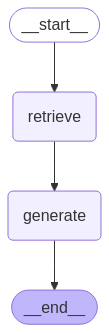

In [17]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
result=graph.invoke({"question":"What is Task Decomposition?"})
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='9dc8b4a2-575a-442c-8062-2df2e43969d5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='a882b648-9524-4bed-907c-79cb2a111c90', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thou